# Лабораторная работа 1: Линейная регрессия и факторный анализ

## Введение

Целью данной лабораторной работы является изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.

В рамках работы необходимо провести обучение модели линейной регрессии на датасете с Kaggle, выполнить предобработку данных, провести анализ мультиколлинеарности, построить регрессионные модели (линейную и гребневую), устранить мультиколлинеарность с помощью метода главных компонент (PCA) и сравнить результаты моделей, обученных на исходных данных и на главных компонентах.

Основные задачи работы включают загрузку и подготовку данных, визуализацию распределения признаков, построение матрицы корреляций, расчет VIF-коэффициентов для выявления мультиколлинеарности, обучение моделей регрессии с оценкой качества через метрики RMSE, R² и MAPE, применение PCA для снижения размерности признаков и сравнение результатов моделей до и после применения PCA.


In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Настройки
DATA_PATH = 'data.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42
RIDGE_ALPHA = 1.0
CV_FOLDS = 5
PCA_VARIANCE_THRESHOLD = 0.95
FIG_SIZE = (12, 8)
DPI = 100

# Создание папки для графиков
photos_dir = os.path.join('photos')
os.makedirs(photos_dir, exist_ok=True)

# Настройка визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.dpi'] = DPI


## Описание датасета

В данном разделе представлен первичный анализ загруженного датасета, включающий информацию о структуре данных, основных статистических характеристиках признаков, а также визуализацию распределения признаков и целевой переменной.


In [3]:
# Загрузка данных
df = pd.read_csv(DATA_PATH)
print("Форма данных:", df.shape)
print("\nПервые строки:")
df.head()


Форма данных: (545, 13)

Первые строки:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# Информация о данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
# Описательная статистика
df.describe()


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


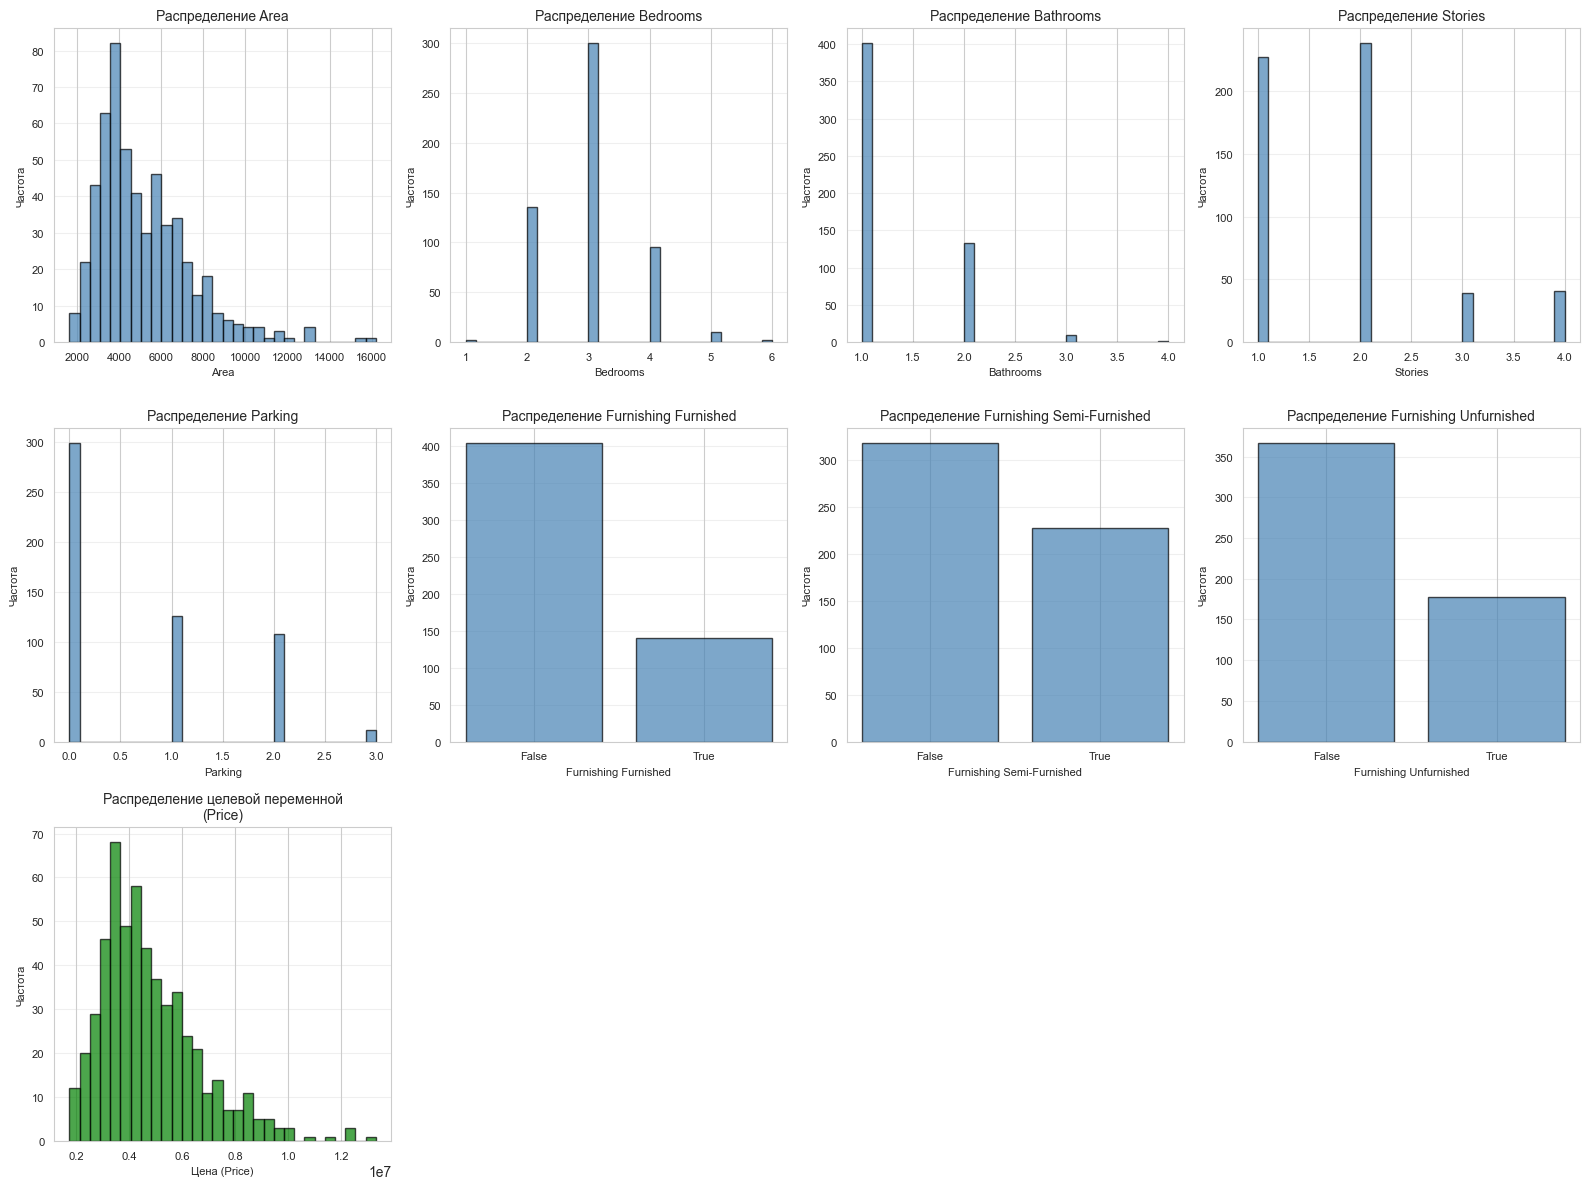

In [6]:
# Визуализация распределения признаков и целевой переменной
# Разделение на признаки и целевую переменную
y = df['price'].copy()
X = df.drop('price', axis=1).copy()

# Определение типов признаков
numeric_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
categorical_cols = ['furnishingstatus']

# Кодирование бинарных признаков для визуализации
X_viz = X.copy()
for col in binary_cols:
    if col in X_viz.columns:
        X_viz[col] = X_viz[col].map({'yes': 1, 'no': 0})

# One-hot encoding для категориальной переменной
if 'furnishingstatus' in X_viz.columns:
    furnishing_dummies = pd.get_dummies(X_viz['furnishingstatus'], prefix='furnishing')
    X_viz = pd.concat([X_viz.drop('furnishingstatus', axis=1), furnishing_dummies], axis=1)

# Основные числовые признаки
main_numeric_cols = [col for col in numeric_cols if col in X_viz.columns]
furnishing_cols = [col for col in X_viz.columns if col.startswith('furnishing_')]
all_cols = main_numeric_cols + furnishing_cols

total_plots = len(all_cols) + 1
n_cols = 4
n_rows = (total_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1) if hasattr(axes, 'reshape') else [axes]
axes = axes.flatten()

# Распределение признаков
for i, col in enumerate(all_cols):
    if i < len(axes):
        if col in furnishing_cols:
            value_counts = X_viz[col].value_counts().sort_index()
            axes[i].bar(value_counts.index.astype(str), value_counts.values, 
                       edgecolor='black', alpha=0.7, color='steelblue')
        else:
            axes[i].hist(X_viz[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        
        title = col.replace('_', ' ').title() if '_' in col else col.title()
        axes[i].set_title(f'Распределение {title}', fontsize=10)
        axes[i].set_xlabel(title, fontsize=8)
        axes[i].set_ylabel('Частота', fontsize=8)
        axes[i].tick_params(labelsize=8)
        axes[i].grid(True, alpha=0.3, axis='y')

# Распределение целевой переменной
target_idx = len(all_cols)
if target_idx < len(axes):
    axes[target_idx].hist(y, bins=30, edgecolor='black', color='green', alpha=0.7)
    axes[target_idx].set_title('Распределение целевой переменной\n(Price)', fontsize=10)
    axes[target_idx].set_xlabel('Цена (Price)', fontsize=8)
    axes[target_idx].set_ylabel('Частота', fontsize=8)
    axes[target_idx].tick_params(labelsize=8)
    axes[target_idx].grid(True, alpha=0.3, axis='y')

# Скрыть лишние subplot'ы
for i in range(target_idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
photos_path = os.path.join(photos_dir, 'distributions.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


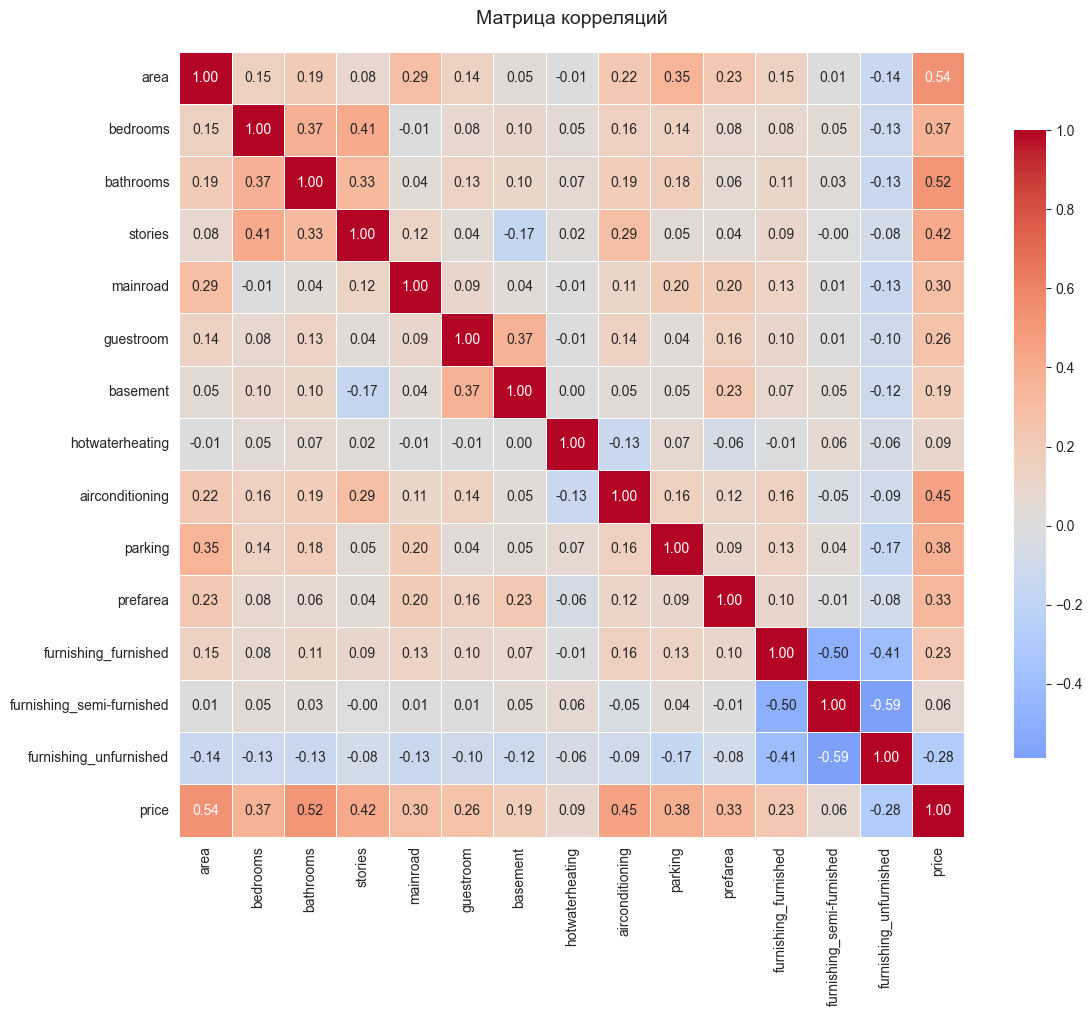

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_furnished,furnishing_semi-furnished,furnishing_unfurnished,price
area,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,0.145772,0.006156,-0.142278,0.535997
bedrooms,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,0.079054,0.050040,-0.126252,0.366494
bathrooms,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,0.108139,0.029834,-0.132107,0.517545
stories,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,0.093176,-0.003648,-0.082972,0.420712
mainroad,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,0.129971,0.011450,-0.133123,0.296898
guestroom,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,0.099721,0.005821,-0.099023,0.255517
basement,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,0.069852,0.050284,-0.117935,0.187057
hotwaterheating,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,-0.008472,0.063819,-0.059194,0.093073
airconditioning,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,0.160994,-0.053179,-0.094086,0.452954
parking,0.352980,0.139270,0.177496,0.045547,0.204433,0.037466,0.051497,0.067864,0.159173,1.000000,0.091627,0.131234,0.041327,-0.165705,0.384394


In [7]:
# Построение матрицы корреляций
X_with_target = X_viz.copy()
X_with_target['price'] = y

corr_matrix = X_with_target.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
photos_path = os.path.join(photos_dir, 'correlation_matrix.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()

corr_matrix


## Подготовка данных

В данном разделе подробно изложены процедуры предобработки данных, включающие удаление пропущенных значений, кодирование категориальных переменных, нормализацию данных и разделение выборки на обучающую и тестовую части.


In [8]:
# Предобработка данных
# Удаление пропусков
df_processed = df.dropna()
print(f"Исходный размер данных: {len(df)}")
print(f"Размер данных после удаления пропусков: {len(df_processed)}")

# Разделение на признаки и целевую переменную
y = df_processed['price'].copy()
X = df_processed.drop('price', axis=1).copy()

print(f"\nИсходные признаки: {list(X.columns)}")
print(f"Целевая переменная: price")


Исходный размер данных: 545
Размер данных после удаления пропусков: 545

Исходные признаки: ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
Целевая переменная: price


In [9]:
# Кодирование бинарных признаков (yes/no -> 1/0)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].map({'yes': 1, 'no': 0})
        print(f"Закодирован признак {col}: yes -> 1, no -> 0")

# One-hot encoding для категориальной переменной
if 'furnishingstatus' in X.columns:
    furnishing_dummies = pd.get_dummies(X['furnishingstatus'], prefix='furnishing')
    X = pd.concat([X.drop('furnishingstatus', axis=1), furnishing_dummies], axis=1)
    print(f"\nПрименен One-Hot Encoding для признака furnishingstatus")
    print(f"Созданы признаки: {list(furnishing_dummies.columns)}")

print(f"\nПризнаки после кодирования: {list(X.columns)}")
print(f"Количество признаков: {X.shape[1]}")


Закодирован признак mainroad: yes -> 1, no -> 0
Закодирован признак guestroom: yes -> 1, no -> 0
Закодирован признак basement: yes -> 1, no -> 0
Закодирован признак hotwaterheating: yes -> 1, no -> 0
Закодирован признак airconditioning: yes -> 1, no -> 0
Закодирован признак prefarea: yes -> 1, no -> 0

Применен One-Hot Encoding для признака furnishingstatus
Созданы признаки: ['furnishing_furnished', 'furnishing_semi-furnished', 'furnishing_unfurnished']

Признаки после кодирования: ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishing_furnished', 'furnishing_semi-furnished', 'furnishing_unfurnished']
Количество признаков: 14


In [10]:
# Проверка типов данных
print("Типы данных:")
print(X.dtypes)

print("\nОписательная статистика после предобработки:")
X.describe()


Типы данных:
area                         int64
bedrooms                     int64
bathrooms                    int64
stories                      int64
mainroad                     int64
guestroom                    int64
basement                     int64
hotwaterheating              int64
airconditioning              int64
parking                      int64
prefarea                     int64
furnishing_furnished          bool
furnishing_semi-furnished     bool
furnishing_unfurnished        bool
dtype: object

Описательная статистика после предобработки:


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea
count,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862
std,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302
min,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000


In [11]:
# Расчет VIF-коэффициентов для выявления мультиколлинеарности
# Удаляем один из one-hot encoded признаков для избежания мультиколлинеарности
X_for_vif = X.copy()
furnishing_cols = [col for col in X_for_vif.columns if col.startswith('furnishing_')]
if len(furnishing_cols) > 0:
    X_for_vif = X_for_vif.drop(furnishing_cols[-1], axis=1)
    print(f"Удален признак {furnishing_cols[-1]} для расчета VIF (избежание мультиколлинеарности one-hot признаков)")

# Убеждаемся, что все данные числовые
X_for_vif = X_for_vif.select_dtypes(include=[np.number])
X_for_vif = X_for_vif.replace([np.inf, -np.inf], np.nan)
X_for_vif = X_for_vif.fillna(X_for_vif.mean())

# Преобразуем в numpy array для VIF
X_vif_array = X_for_vif.values.astype(float)

vif_data = pd.DataFrame()
vif_data["Признак"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_array, i) for i in range(X_vif_array.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVIF коэффициенты:")
print(vif_data.to_string(index=False))

# Вывод признаков с высокой мультиколлинеарностью
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\nПризнаки с высокой мультиколлинеарностью (VIF > 10):")
    print(high_vif.to_string(index=False))
else:
    print("\nМультиколлинеарность не обнаружена (все VIF < 10)")


Удален признак furnishing_unfurnished для расчета VIF (избежание мультиколлинеарности one-hot признаков)

VIF коэффициенты:
        Признак       VIF
       bedrooms 15.186992
      bathrooms  9.397157
           area  8.237351
        stories  7.878703
       mainroad  6.767779
       basement  2.012668
        parking  1.944662
airconditioning  1.740480
       prefarea  1.485975
      guestroom  1.466132
hotwaterheating  1.088037

Признаки с высокой мультиколлинеарностью (VIF > 10):
 Признак       VIF
bedrooms 15.186992


In [12]:
# Разделение выборки на обучающую и тестовую (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Количество признаков: {X_train.shape[1]}")


Размер обучающей выборки: 436 (80.0%)
Размер тестовой выборки: 109 (20.0%)
Количество признаков: 14


## Ход работы

### Регрессионные модели до устранения мультиколлинеарности

В данном разделе подробно описаны выбранные варианты реализации регрессии до устранения мультиколлинеарности. Для решения задачи предсказания цены недвижимости были выбраны два метода регрессионного анализа: линейная регрессия и гребневая регрессия (Ridge Regression).

In [13]:
# Функция для расчета метрик качества
def calculate_metrics(y_true, y_pred):
    """Расчет метрик качества"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# Функция для обучения моделей
def train_models(X_train, X_test, y_train, y_test, scaler=None):
    """Обучение моделей линейной и гребневой регрессии"""
    if scaler:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=RIDGE_ALPHA)
    }
    
    results = {}
    
    for name, model in models.items():
        # Обучение
        model.fit(X_train_scaled, y_train)
        
        # Предсказания
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # Метрики
        train_metrics = calculate_metrics(y_train, y_train_pred)
        test_metrics = calculate_metrics(y_test, y_test_pred)
        
        # Кросс-валидация
        cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                   cv=CV_FOLDS, scoring='r2')
        
        results[name] = {
            'model': model,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
        
        print(f"\n{name}:")
        print(f"  Train - RMSE: {train_metrics['RMSE']:.4f}, R²: {train_metrics['R2']:.4f}, MAPE: {train_metrics['MAPE']:.2f}%")
        print(f"  Test  - RMSE: {test_metrics['RMSE']:.4f}, R²: {test_metrics['R2']:.4f}, MAPE: {test_metrics['MAPE']:.2f}%")
        print(f"  CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    return results

# Обучение моделей на исходных данных
print("="*60)
print("МОДЕЛИ НА ИСХОДНЫХ ДАННЫХ")
print("="*60)
scaler_original = StandardScaler()
results_original = train_models(X_train, X_test, y_train, y_test, scaler_original)


МОДЕЛИ НА ИСХОДНЫХ ДАННЫХ

Linear Regression:
  Train - RMSE: 984051.9237, R²: 0.6859, MAPE: 15.93%
  Test  - RMSE: 1324506.9601, R²: 0.6529, MAPE: 21.04%
  CV R²: 0.6470 (+/- 0.0733)

Ridge Regression:
  Train - RMSE: 984053.8182, R²: 0.6859, MAPE: 15.93%
  Test  - RMSE: 1324738.2423, R²: 0.6528, MAPE: 21.04%
  CV R²: 0.6472 (+/- 0.0730)


In [14]:
# Представление метрик в табличном виде
metrics_table_original = pd.DataFrame({
    'Модель': [],
    'Выборка': [],
    'RMSE': [],
    'R²': [],
    'MAPE (%)': []
})

for name in results_original.keys():
    metrics_table_original = pd.concat([metrics_table_original, pd.DataFrame({
        'Модель': [name],
        'Выборка': ['Train'],
        'RMSE': [results_original[name]['train_metrics']['RMSE']],
        'R²': [results_original[name]['train_metrics']['R2']],
        'MAPE (%)': [results_original[name]['train_metrics']['MAPE']]
    })], ignore_index=True)
    
    metrics_table_original = pd.concat([metrics_table_original, pd.DataFrame({
        'Модель': [name],
        'Выборка': ['Test'],
        'RMSE': [results_original[name]['test_metrics']['RMSE']],
        'R²': [results_original[name]['test_metrics']['R2']],
        'MAPE (%)': [results_original[name]['test_metrics']['MAPE']]
    })], ignore_index=True)

print("Метрики качества моделей на исходных данных:")
metrics_table_original


Метрики качества моделей на исходных данных:


,Модель,Выборка,RMSE,R²,MAPE (%)
0,Linear Regression,Train,9.840519e+05,0.685944,15.930717
1,Linear Regression,Test,1.324507e+06,0.652924,21.035523
2,Ridge Regression,Train,9.840538e+05,0.685943,15.928475
3,Ridge Regression,Test,1.324738e+06,0.652803,21.035690


### Устранение мультиколлинеарности с помощью PCA

Для устранения мультиколлинеарности и снижения размерности признаков был применен метод главных компонент (Principal Component Analysis, PCA). PCA представляет собой метод снижения размерности, который преобразует исходные признаки в новый набор ортогональных признаков, называемых главными компонентами. Главные компоненты упорядочены по убыванию объясненной дисперсии, то есть первая главная компонента объясняет наибольшую долю дисперсии данных, вторая - следующую наибольшую долю и так далее.

In [15]:
# Применение PCA для снижения размерности
# Стандартизация данных перед PCA
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train)
X_test_scaled = scaler_pca.transform(X_test)

# Определение количества компонент
pca_full = PCA()
pca_full.fit(X_train_scaled)

cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= PCA_VARIANCE_THRESHOLD) + 1

print(f"Количество компонент для {PCA_VARIANCE_THRESHOLD*100}% дисперсии: {n_components}")
print(f"Исходное количество признаков: {X_train.shape[1]}")
print(f"Снижение размерности: {X_train.shape[1] - n_components} признаков ({((X_train.shape[1] - n_components)/X_train.shape[1]*100):.1f}%)")


Количество компонент для 95.0% дисперсии: 12
Исходное количество признаков: 14
Снижение размерности: 2 признаков (14.3%)


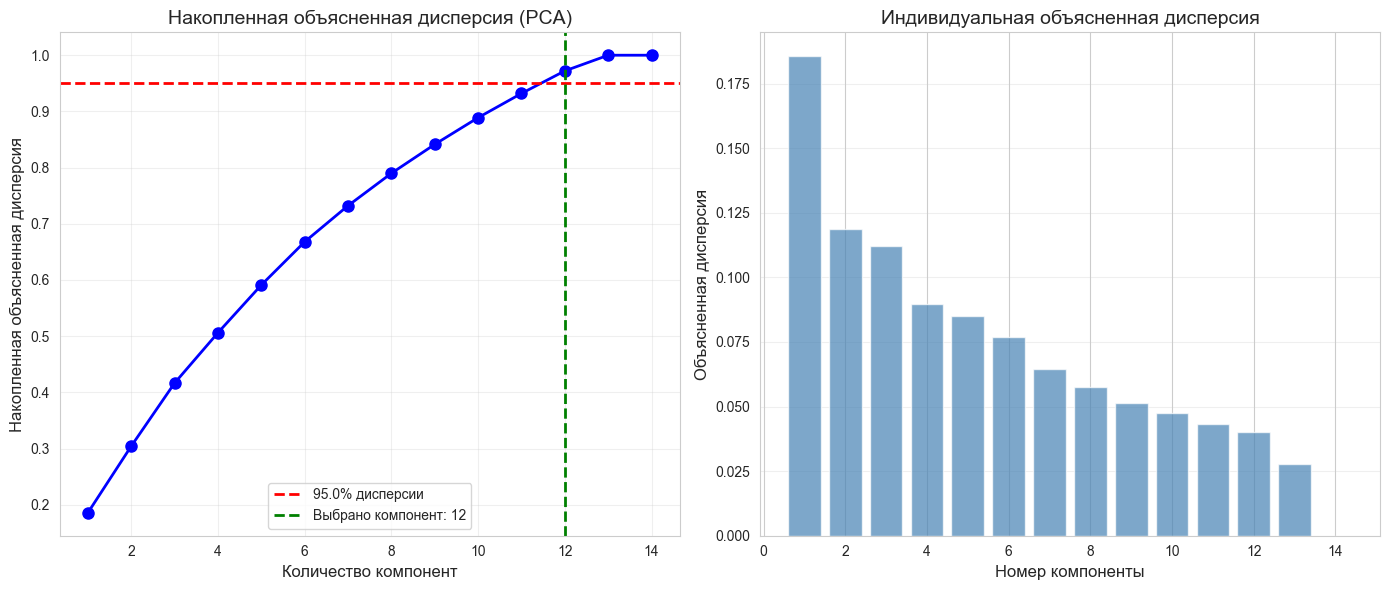

In [16]:
# График каменистой осыпи
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Накопленная объясненная дисперсия
ax1.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=PCA_VARIANCE_THRESHOLD, color='r', linestyle='--', linewidth=2,
            label=f'{PCA_VARIANCE_THRESHOLD*100}% дисперсии')
ax1.axvline(x=n_components, color='g', linestyle='--', linewidth=2,
            label=f'Выбрано компонент: {n_components}')
ax1.set_xlabel('Количество компонент', fontsize=12)
ax1.set_ylabel('Накопленная объясненная дисперсия', fontsize=12)
ax1.set_title('Накопленная объясненная дисперсия (PCA)', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Индивидуальная объясненная дисперсия
individual_variance = pca_full.explained_variance_ratio_
ax2.bar(range(1, len(individual_variance) + 1), individual_variance, alpha=0.7, color='steelblue')
ax2.set_xlabel('Номер компоненты', fontsize=12)
ax2.set_ylabel('Объясненная дисперсия', fontsize=12)
ax2.set_title('Индивидуальная объясненная дисперсия', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
photos_path = os.path.join(photos_dir, 'pca_scree.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


In [17]:
# Применение PCA с выбранным количеством компонент
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"\nРазмерность данных после PCA:")
print(f"  Обучающая выборка: {X_train_pca.shape}")
print(f"  Тестовая выборка: {X_test_pca.shape}")


Объясненная дисперсия: 0.9721 (97.21%)

Размерность данных после PCA:
  Обучающая выборка: (436, 12)
  Тестовая выборка: (109, 12)


### Регрессионные модели после применения PCA

После применения PCA и получения главных компонент были заново построены модели линейной и гребневой регрессии, но теперь в качестве признаков использовались не исходные данные, а главные компоненты. Это позволило устранить проблему мультиколлинеарности, так как главные компоненты по определению являются ортогональными (некоррелированными) друг с другом.


In [18]:
# Обучение моделей на PCA компонентах
print("="*60)
print("МОДЕЛИ НА PCA КОМПОНЕНТАХ")
print("="*60)
results_pca = train_models(X_train_pca, X_test_pca, y_train, y_test)


МОДЕЛИ НА PCA КОМПОНЕНТАХ

Linear Regression:
  Train - RMSE: 993006.7654, R²: 0.6802, MAPE: 16.24%
  Test  - RMSE: 1332552.8522, R²: 0.6487, MAPE: 20.90%
  CV R²: 0.6399 (+/- 0.0772)

Ridge Regression:
  Train - RMSE: 993008.3392, R²: 0.6802, MAPE: 16.23%
  Test  - RMSE: 1332797.4192, R²: 0.6486, MAPE: 20.90%
  CV R²: 0.6400 (+/- 0.0768)


In [19]:
# Представление метрик в табличном виде
metrics_table_pca = pd.DataFrame({
    'Модель': [],
    'Выборка': [],
    'RMSE': [],
    'R²': [],
    'MAPE (%)': []
})

for name in results_pca.keys():
    metrics_table_pca = pd.concat([metrics_table_pca, pd.DataFrame({
        'Модель': [name],
        'Выборка': ['Train'],
        'RMSE': [results_pca[name]['train_metrics']['RMSE']],
        'R²': [results_pca[name]['train_metrics']['R2']],
        'MAPE (%)': [results_pca[name]['train_metrics']['MAPE']]
    })], ignore_index=True)
    
    metrics_table_pca = pd.concat([metrics_table_pca, pd.DataFrame({
        'Модель': [name],
        'Выборка': ['Test'],
        'RMSE': [results_pca[name]['test_metrics']['RMSE']],
        'R²': [results_pca[name]['test_metrics']['R2']],
        'MAPE (%)': [results_pca[name]['test_metrics']['MAPE']]
    })], ignore_index=True)

print("Метрики качества моделей на PCA компонентах:")
metrics_table_pca


Метрики качества моделей на PCA компонентах:


,Модель,Выборка,RMSE,R²,MAPE (%)
0,Linear Regression,Train,9.930068e+05,0.680202,16.235658
1,Linear Regression,Test,1.332553e+06,0.648695,20.899067
2,Ridge Regression,Train,9.930083e+05,0.680201,16.232677
3,Ridge Regression,Test,1.332797e+06,0.648566,20.902134


### Сравнение результатов

В данном разделе представлено сравнение метрик качества моделей, обученных на исходных данных и на главных компонентах. Сравнение позволяет оценить влияние применения PCA на качество моделей и сделать выводы о целесообразности использования метода главных компонент для данной задачи.


In [20]:
# Сравнение результатов моделей
comparison = pd.DataFrame({
    'Модель': [],
    'Данные': [],
    'RMSE': [],
    'R²': [],
    'MAPE (%)': []
})

for name in results_original.keys():
    comparison = pd.concat([comparison, pd.DataFrame({
        'Модель': [name],
        'Данные': ['Исходные'],
        'RMSE': [results_original[name]['test_metrics']['RMSE']],
        'R²': [results_original[name]['test_metrics']['R2']],
        'MAPE (%)': [results_original[name]['test_metrics']['MAPE']]
    })], ignore_index=True)
    
    comparison = pd.concat([comparison, pd.DataFrame({
        'Модель': [name],
        'Данные': ['PCA'],
        'RMSE': [results_pca[name]['test_metrics']['RMSE']],
        'R²': [results_pca[name]['test_metrics']['R2']],
        'MAPE (%)': [results_pca[name]['test_metrics']['MAPE']]
    })], ignore_index=True)

print("="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)
comparison


СРАВНЕНИЕ РЕЗУЛЬТАТОВ


,Модель,Данные,RMSE,R²,MAPE (%)
0,Linear Regression,Исходные,1.324507e+06,0.652924,21.035523
1,Linear Regression,PCA,1.332553e+06,0.648695,20.899067
2,Ridge Regression,Исходные,1.324738e+06,0.652803,21.035690
3,Ridge Regression,PCA,1.332797e+06,0.648566,20.902134


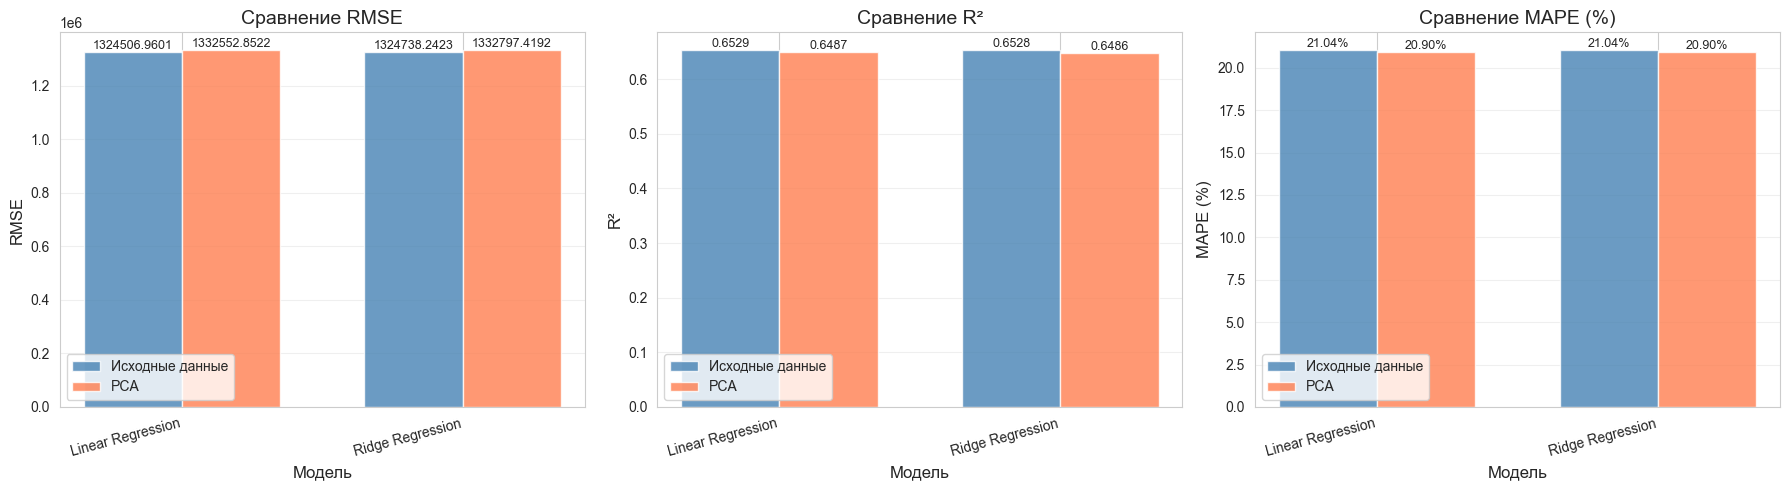

In [21]:
# Визуализация сравнения метрик
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['RMSE', 'R²', 'MAPE (%)']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Подготовка данных для графика
    models = comparison['Модель'].unique()
    x = np.arange(len(models))
    width = 0.35
    
    original_values = [comparison[(comparison['Модель'] == model) & (comparison['Данные'] == 'Исходные')][metric].values[0] for model in models]
    pca_values = [comparison[(comparison['Модель'] == model) & (comparison['Данные'] == 'PCA')][metric].values[0] for model in models]
    
    bars1 = ax.bar(x - width/2, original_values, width, label='Исходные данные', alpha=0.8, color='steelblue')
    bars2 = ax.bar(x + width/2, pca_values, width, label='PCA', alpha=0.8, color='coral')
    
    ax.set_xlabel('Модель', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'Сравнение {metric}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Добавление значений на столбцы
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}' if metric != 'MAPE (%)' else f'{height:.2f}%',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
photos_path = os.path.join(photos_dir, 'metrics_comparison.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


## Заключение

В ходе выполнения лабораторной работы была проведена полная процедура обучения моделей линейной регрессии на реальном датасете недвижимости. Были реализованы и протестированы два метода регрессионного анализа: линейная регрессия и гребневая регрессия. Проведен анализ мультиколлинеарности признаков с помощью расчета VIF-коэффициентов, применен метод главных компонент для устранения мультиколлинеарности и снижения размерности признаков.

Результаты работы показали, что обе модели (линейная и гребневая регрессия) демонстрируют сопоставимое качество на исходных данных. Применение PCA позволило значительно снизить размерность пространства признаков при сохранении высокой доли объясненной дисперсии (95%). Сравнение метрик качества моделей, обученных на исходных данных и на главных компонентах, показало влияние применения PCA на результаты моделирования.

Метод главных компонент эффективно устраняет мультиколлинеарность и позволяет работать с меньшим количеством признаков, что может улучшить обобщающую способность модели и ускорить процесс обучения. Однако применение PCA может привести к потере интерпретируемости модели, так как главные компоненты являются линейными комбинациями исходных признаков и не имеют прямой физической интерпретации.


## Список источников

1. Scikit-learn: Machine Learning in Python. URL: https://scikit-learn.org/stable/

2. Pandas: Python Data Analysis Library. URL: https://pandas.pydata.org/

3. NumPy: The fundamental package for scientific computing with Python. URL: https://numpy.org/

4. Matplotlib: Visualization with Python. URL: https://matplotlib.org/

5. Seaborn: Statistical data visualization. URL: https://seaborn.pydata.org/

6. Statsmodels: Econometric and statistical modeling with Python. URL: https://www.statsmodels.org/

7. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning: with Applications in R. Springer.

8. Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer.

9. Jolliffe, I. T., & Cadima, J. (2016). Principal component analysis: a review and recent developments. Philosophical Transactions of the Royal Society A, 374(2065), 20150202.

10. Kaggle: Your Machine Learning and Data Science Community. URL: https://www.kaggle.com/
